## IMPORTS

In [1]:
import tifffile
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import SAM
from pathlib import Path
import torch
from codecarbon import EmissionsTracker
from datetime import datetime
import csv
from skimage.metrics import structural_similarity as ssim  


## PARAMETRES

In [3]:

GRID_STRIDE   = 64                   # densité des points
POINTS_PER_CALL = 30                # taille des chunks envoyés à SAM
MIN_AREA      = 300                  # aire min d’un masque (en pixels)
CONF_THR      = 0.7                 #  seuil min confiance de SAM
DEDUP_IOU_THR = 0.90                 # seuil de dé-duplication
MIN_MASK_REGION_AREA = 200
IMAGE_3D_PATH = "../data/Romane_Martin_urne_sature_10-4.tif"
SAM_WEIGHTS = "../data/sam_b.pt"   #path sam en local ou bien download from ultralytics
POINT_LABEL = 1


## UTILS

In [3]:
def make_grid_points(h, w, stride, label=1):
    xs = np.arange(stride // 2, w, stride)
    ys = np.arange(stride // 2, h, stride)
    pts = [(int(x), int(y)) for y in ys for x in xs]  # (x, y)
    lbls = [label] * len(pts)
    return pts, lbls

def dedup_by_iou(masks, iou_thr=0.9, min_area=0):
    keep = []
    for m in masks:
        if m.sum() < min_area:
            continue
        if any( (np.logical_and(m, k).sum() / max(np.logical_or(m, k).sum(), 1)) > iou_thr
                for k in keep ):
            continue
        keep.append(m)
    return keep


def colorize_masks(image_gray, masks_bool, seed=42):

    out = np.dstack([image_gray, image_gray, image_gray]).copy()  # [H, W, 3]
    out = out.astype(np.uint8, copy=False)
    rng = np.random.default_rng(seed)
    for m in masks_bool:
        out[m] = rng.integers(0, 256, size=3, dtype=np.uint8)  # couleur aléatoire (R,G,B)
    return out



## CHARGEMENT DONNEES & MODELE


## chargement données

In [3]:
def to_sam_handled_picture(picture_3D: np.ndarray) -> np.ndarray:
    return np.repeat(picture_3D[..., np.newaxis], 3, -1)

In [4]:
# exemple extraction slice au milieu
vol = tifffile.imread(IMAGE_3D_PATH)
print(f"Volume: shape={vol.shape}, dtype={vol.dtype}")
mid = len(vol) // 2
sl  = vol[mid]

Volume: shape=(1735, 1808, 1595), dtype=uint8


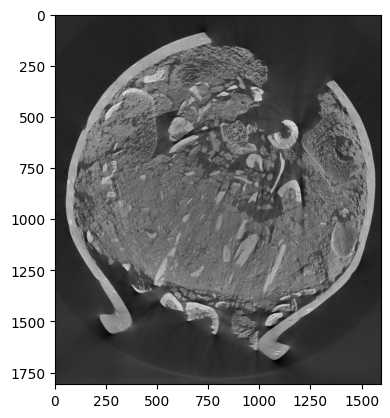

In [5]:
plt.imshow(sl, cmap="gray")
plt.show()

## chargement SAM

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if not Path(SAM_WEIGHTS).exists():
    print(f"Downloading {SAM_WEIGHTS}...")
    model = SAM(SAM_WEIGHTS)
else:
    print(f"{SAM_WEIGHTS} already exists locally")
    model = SAM(SAM_WEIGHTS)

print("SAM chargé")

Device: cuda
../data/sam_b.pt already exists locally
SAM chargé


## INFERENCE PAR CHUNKS DE POINTS


In [8]:
from typing import Union

def run_sam_chunked_points(model: SAM, image, points: Union[list[tuple[int, int]], int], labels=None,
                           conf=0.35, points_per_call=25, device="cpu", binarize_thr=0.5):
    img = image if image.ndim == 3 else np.dstack([image, image, image])
    # >>>> ???? >>>>
    if img.dtype != np.uint8:
        mn, mx = float(img.min()), float(img.max())
        img = ((img - mn) / (mx - mn) * 255).astype(np.uint8) if mx > mn else np.zeros_like(img, dtype=np.uint8)
    img = np.ascontiguousarray(img)
    # <<<< ???? <<<<
    masks = []
    with torch.inference_mode():
        if isinstance(points, int):
            r = model.predict(source=img, points_stride=points, points_batch_size=points_per_call, conf=conf, device=device)
            if getattr(r, "masks", None) is not None and r.masks is not None:
                t = r.masks.data  # [N,H,W]
                arr = (t > binarize_thr).cpu().numpy()
                masks.extend(mi.astype(bool) for mi in arr)
        else:
            for i in range(0, len(points), points_per_call):
                r = model.predict(source=img,
                                  points=points[i:i+points_per_call],
                                  labels=labels[i:i+points_per_call],
                                  conf=conf, device=device)[0]
                if getattr(r, "masks", None) is not None and r.masks is not None:
                    t = r.masks.data  # [N,H,W]
                    arr = (t > binarize_thr).cpu().numpy()
                    masks.extend(mi.astype(bool) for mi in arr)
        if device == "cuda":
            torch.cuda.empty_cache()
    return masks # non dédupliqués


### grille de points et inférence

In [9]:
type(sl)

numpy.ndarray

In [10]:
tracker = EmissionsTracker()
tracker.start()
H, W = sl.shape[:2]
points, labels = make_grid_points(H, W, GRID_STRIDE, label=POINT_LABEL)
print(f"Points de grille: {len(points)}  (stride={GRID_STRIDE})")

[codecarbon WARNING @ 16:13:09] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 16:13:09] [setup] RAM Tracking...
[codecarbon INFO @ 16:13:09] [setup] CPU Tracking...
[codecarbon WARNING @ 16:13:10] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 16:13:10] CPU Model on constant consumption mode: Intel(R) Xeon(R) W-1270 CPU @ 3.40GHz
[codecarbon WARNING @ 16:13:10] No CPU tracking mode found. Falling back on CPU load mode.
[codecarbon INFO @ 16:13:10] [setup] GPU Tracking...
[codecarbon INFO @ 16:13:10] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:13:10] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: cpu_load
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 

Points de grille: 700  (stride=64)


In [11]:
raw_masks = run_sam_chunked_points(model, sl, points, labels, conf=CONF_THR,points_per_call=POINTS_PER_CALL, device=device)


0: 1024x1024 1 0, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 27, 1 28, 1 29, 463.7ms
Speed: 13.9ms preprocess, 463.7ms inference, 20.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 301.6ms
Speed: 6.7ms preprocess, 301.6ms inference, 5.7ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 25, 1 26, 1 27, 1 28, 1 29, 302.2ms
Speed: 6.7ms preprocess, 302.2ms inference, 5.6ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 17, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 2

[codecarbon INFO @ 16:13:43] Energy consumed for RAM : 0.000167 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 16:13:44] Delta energy consumed for CPU with cpu_load : 0.000032 kWh, power : 8.021877731 W
[codecarbon INFO @ 16:13:44] Energy consumed for All CPU : 0.000067 kWh
[codecarbon INFO @ 16:13:44] Energy consumed for all GPUs : 0.000543 kWh. Total GPU Power : 27.96532348999556 W
[codecarbon INFO @ 16:13:44] 0.000776 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:14:13] Energy consumed for RAM : 0.000328 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 16:14:14] Delta energy consumed for CPU with cpu_load : 0.000032 kWh, power : 8.0223290765 W
[codecarbon INFO @ 16:14:14] Energy consumed for All CPU : 0.000131 kWh
[codecarbon INFO @ 16:14:14] Energy consumed for all GPUs : 0.000619 kWh. Total GPU Power : 8.94360681768314 W
[codecarbon INFO @ 16:14:14] 0.001078 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbo

In [12]:
masks = dedup_by_iou(raw_masks, iou_thr=DEDUP_IOU_THR, min_area=MIN_AREA)
print(f" {len(masks)} masques après filtrage & dé-dup")

[codecarbon INFO @ 16:13:28] Energy consumed for RAM : 0.000086 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 16:13:29] Delta energy consumed for CPU with cpu_load : 0.000035 kWh, power : 8.0273490176 W
[codecarbon INFO @ 16:13:29] Energy consumed for All CPU : 0.000035 kWh
[codecarbon INFO @ 16:13:29] Energy consumed for all GPUs : 0.000426 kWh. Total GPU Power : 95.86176895360703 W
[codecarbon INFO @ 16:13:29] 0.000547 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:13:58] Energy consumed for RAM : 0.000247 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 16:13:59] Delta energy consumed for CPU with cpu_load : 0.000032 kWh, power : 8.0216318915 W
[codecarbon INFO @ 16:13:59] Energy consumed for All CPU : 0.000099 kWh
[codecarbon INFO @ 16:13:59] Energy consumed for all GPUs : 0.000582 kWh. Total GPU Power : 9.299706692203562 W
[codecarbon INFO @ 16:13:59] 0.000928 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecar

 187 masques après filtrage & dé-dup


## SAVE VISUALISATION

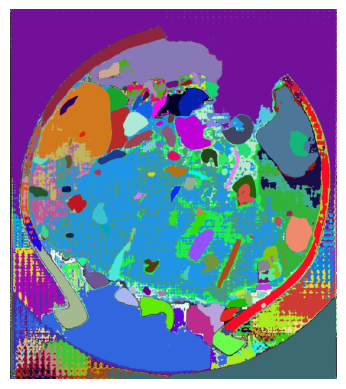

 Sauvegarde: sam_colored_slice_867.png


In [13]:

if len(masks) == 0:
    print(" Aucun objet détecté ")
else:
    masks_sorted = sorted(masks, key=lambda x: x.sum(), reverse=True)
    colored = colorize_masks(sl, masks_sorted, seed=0)
    plt.imshow(colored)
    plt.axis("off")
    plt.show()
    cv2.imwrite(f"sam_colored_slice_{mid}.png", colored)
    print(f" Sauvegarde: sam_colored_slice_{mid}.png")


### WRITE CODECARBONE RESULTS AND STOP TRACKER

In [14]:
emissions= tracker.stop()
with open("emissions.csv", "a", newline="") as f:
    writer = csv.writer(f)
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    writer.writerow([timestamp, emissions])


[codecarbon INFO @ 16:15:15] Energy consumed for RAM : 0.000654 kWh. RAM Power : 20.0 W
[codecarbon INFO @ 16:15:15] Delta energy consumed for CPU with cpu_load : 0.000002 kWh, power : 8.022694448000003 W
[codecarbon INFO @ 16:15:15] Energy consumed for All CPU : 0.000263 kWh
[codecarbon INFO @ 16:15:15] Energy consumed for all GPUs : 0.000765 kWh. Total GPU Power : 8.26721099238564 W
[codecarbon INFO @ 16:15:15] 0.001683 kWh of electricity and 0.000000 L of water were used since the beginning.


In [14]:
from tqdm import tqdm

# ============================================================================
# FONCTION SIMPLIFIÉE: CALCULER SSIM ENTRE COUPES CONSÉCUTIVES
# ============================================================================
def calculate_consecutive_ssim(vol):
    """
    Calcule uniquement les SSIM entre coupes consécutives (i, i+1)
    
    Args:
        vol: Volume 3D (Z, Y, X)
    
    Returns:
        ssim_values: Array des SSIM [slice_0 vs slice_1, slice_1 vs slice_2, ...]
        indices: Array des indices [0, 1, 2, ..., n-2]
    """
    n_slices = vol.shape[0]
    ssim_values = np.zeros(n_slices - 1)
    
    print(f"\n{'='*60}")
    print(f"🔄 CALCUL SSIM ENTRE COUPES CONSÉCUTIVES")
    print(f"{'='*60}")
    print(f"Nombre de coupes: {n_slices}")
    print(f"Nombre de comparaisons: {n_slices - 1}")
    
    # Calculer avec barre de progression
    for i in tqdm(range(n_slices - 1), desc="Calcul SSIM", unit="comp"):
        slice_i = vol[i, :, :]
        slice_j = vol[i + 1, :, :]
        ssim_values[i] = ssim(slice_i, slice_j, data_range=255)
    
    indices = np.arange(n_slices - 1)
    
    print(f"\n✅ SSIM calculés avec succès!")
    print(f"   Nombre de valeurs: {len(ssim_values)}")
    print(f"   SSIM min: {ssim_values.min():.4f} (entre coupes {np.argmin(ssim_values)} et {np.argmin(ssim_values)+1})")
    print(f"   SSIM max: {ssim_values.max():.4f}")
    print(f"   SSIM moyen: {ssim_values.mean():.4f}")
    
    return ssim_values, indices


# ============================================================================
# FONCTION: PLOT SIMPLE DU SSIM
# ============================================================================
def plot_ssim_simple(ssim_values, indices):
    """
    Affiche simplement les SSIM avec la moyenne - sans détection ni statistiques
    
    Args:
        ssim_values: Array des SSIM
        indices: Array des indices
    """
    fig, ax = plt.subplots(1, 1, figsize=(14, 6))
    
    # Plot des SSIM
    ax.plot(indices, ssim_values, 'b-', linewidth=2, marker='o', markersize=3, label='SSIM')
    
    # Ligne de moyenne
    mean_ssim = np.mean(ssim_values)
    ax.axhline(y=mean_ssim, color='r', linestyle='--', 
               linewidth=2, label=f'Moyenne = {mean_ssim:.4f}')
    
    # Labels et titre
    ax.set_xlabel('Index de coupe Z', fontsize=12, fontweight='bold')
    ax.set_ylabel('SSIM', fontsize=12, fontweight='bold')
    ax.set_title('SSIM entre coupes consécutives', fontsize=14, fontweight='bold', pad=15)
    
    # Grille et légende
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(fontsize=11, loc='best')
    ax.set_ylim([0, 1.05])
    
    plt.tight_layout()
    plt.show()


# ============================================================================
# FONCTION: CALCULER SSIM AVEC UN DELTA SPÉCIFIQUE
# ============================================================================
def calculate_ssim_with_delta(vol, delta=1):
    """
    Calcule les SSIM avec un espacement donné entre les coupes
    
    Args:
        vol: Volume 3D (Z, Y, X)
        delta: Espacement entre les coupes (1=consécutif, 2=tous les 2, etc.)
    
    Returns:
        ssim_values: Array des SSIM
        indices: Array des indices de début
    """
    n_slices = vol.shape[0]
    ssim_values = []
    indices = []
    
    print(f"\n{'='*60}")
    print(f"🔄 CALCUL SSIM AVEC DELTA={delta}")
    print(f"{'='*60}")
    print(f"Nombre de coupes: {n_slices}")
    
    z = 0
    with tqdm(desc=f"Calcul SSIM (delta={delta})", unit="comp") as pbar:
        while z + delta < n_slices:
            slice_i = vol[z, :, :]
            slice_j = vol[z + delta, :, :]
            ssim_values.append(ssim(slice_i, slice_j, data_range=255))
            indices.append(z)
            z += delta
            pbar.update(1)
    
    ssim_values = np.array(ssim_values)
    indices = np.array(indices)
    
    print(f"✅ SSIM calculés: {len(ssim_values)} valeurs")
    
    return ssim_values, indices


🔄 CALCUL SSIM ENTRE COUPES CONSÉCUTIVES
Nombre de coupes: 1735
Nombre de comparaisons: 1734


Calcul SSIM: 100%|██████████| 1734/1734 [06:12<00:00,  4.65comp/s]


✅ SSIM calculés avec succès!
   Nombre de valeurs: 1734
   SSIM min: 0.7347 (entre coupes 895 et 896)
   SSIM max: 0.9905
   SSIM moyen: 0.8647

💾 Résultats sauvegardés: ssim_consecutive.npy


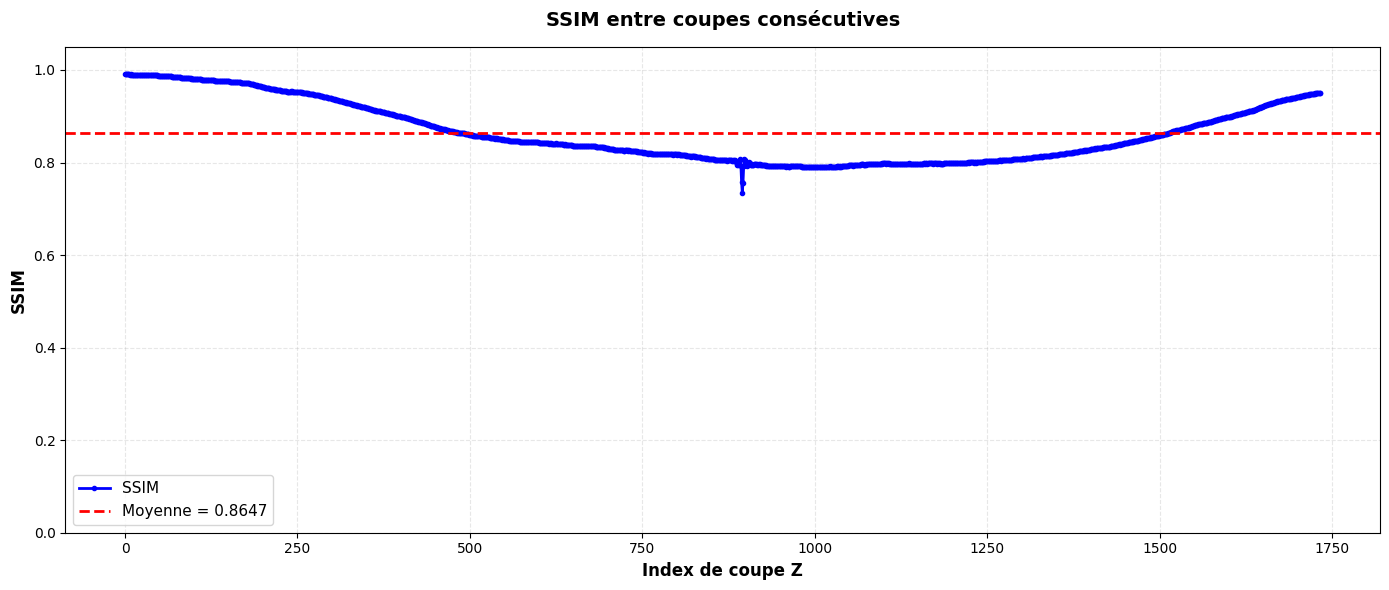

In [ ]:
# ============================================================================
# CALCUL ET VISUALISATION SIMPLE DES SSIM
# ============================================================================

# 1. Calculer les SSIM entre coupes consécutives
#ssim_values, indices = calculate_consecutive_ssim(vol)

ssim_values = np.load("ssim_consecutive.npy")
indices = np.arange(len(ssim_values))  # si indices n’ont pas été sauvegardés
# 2. Sauvegarder les résultats
np.save("ssim_consecutive.npy", ssim_values)
print("\n💾 Résultats sauvegardés: ssim_consecutive.npy")

# 3. Plot simple : SSIM + moyenne uniquement
plot_ssim_simple(ssim_values, indices)

In [10]:
# ============================================================================
# ANALYSE MANUELLE DES SSIM (à votre convenance)
# ============================================================================

# Vous pouvez maintenant analyser les données comme vous voulez :

# Trouver les SSIM les plus faibles
min_ssim_idx = np.argmin(ssim_values)
print(f"\nSSIM minimum: {ssim_values[min_ssim_idx]:.4f} entre coupes {min_ssim_idx} et {min_ssim_idx+1}")

# Trouver toutes les valeurs sous un certain seuil
threshold = 0.85
low_ssim_indices = np.where(ssim_values < threshold)[0]
print(f"\nNombre de SSIM < {threshold}: {len(low_ssim_indices)}")
if len(low_ssim_indices) > 0:
    print("Indices concernés:")
    for idx in low_ssim_indices[:10]:  # Afficher les 10 premiers
        print(f"  Coupe {idx} → {idx+1}: SSIM = {ssim_values[idx]:.4f}")

# Statistiques
print(f"\nStatistiques:")
print(f"  Moyenne: {ssim_values.mean():.4f}")
print(f"  Médiane: {np.median(ssim_values):.4f}")
print(f"  Écart-type: {ssim_values.std():.4f}")


SSIM minimum: 0.7347 entre coupes 895 et 896

Nombre de SSIM < 0.85: 929
Indices concernés:
  Coupe 547 → 548: SSIM = 0.8495
  Coupe 548 → 549: SSIM = 0.8498
  Coupe 549 → 550: SSIM = 0.8487
  Coupe 550 → 551: SSIM = 0.8488
  Coupe 551 → 552: SSIM = 0.8479
  Coupe 552 → 553: SSIM = 0.8484
  Coupe 553 → 554: SSIM = 0.8484
  Coupe 554 → 555: SSIM = 0.8481
  Coupe 555 → 556: SSIM = 0.8476
  Coupe 556 → 557: SSIM = 0.8479

Statistiques:
  Moyenne: 0.8647
  Médiane: 0.8443
  Écart-type: 0.0642



Delta=1: 1734 valeurs extraites (pas de recalcul!)

Delta=2: 867 valeurs extraites (pas de recalcul!)

Delta=5: 347 valeurs extraites (pas de recalcul!)

Delta=10: 174 valeurs extraites (pas de recalcul!)

Delta=20: 87 valeurs extraites (pas de recalcul!)

Delta=50: 35 valeurs extraites (pas de recalcul!)

Delta=100: 18 valeurs extraites (pas de recalcul!)


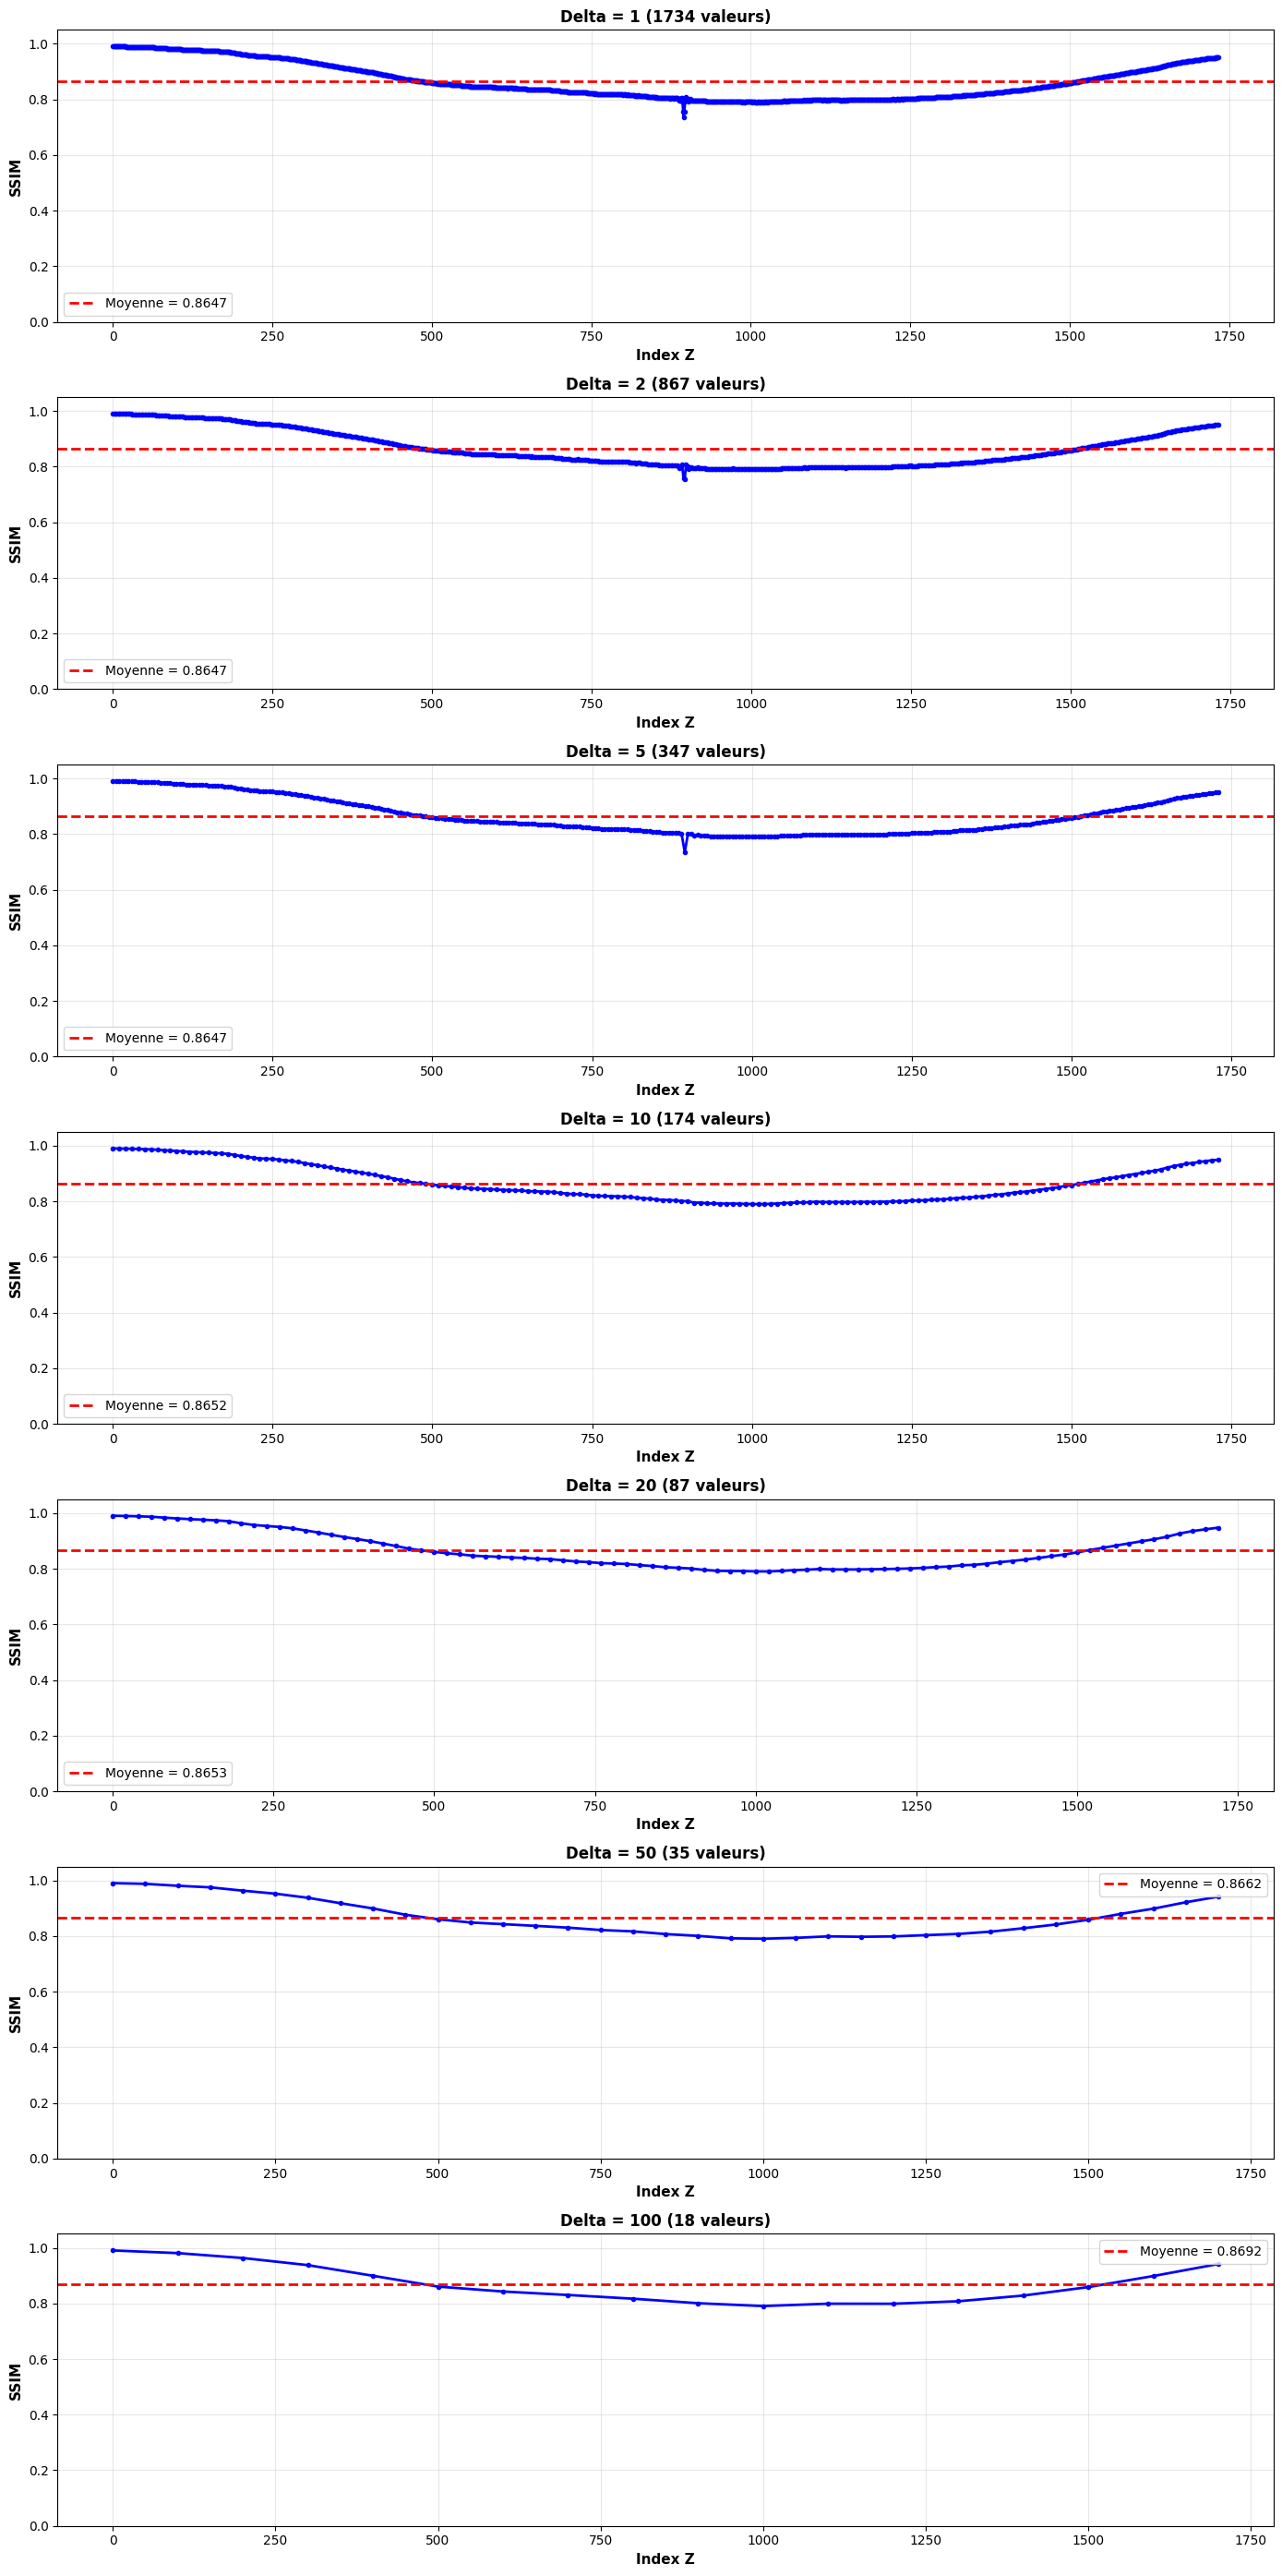

In [ ]:
# ============================================================================
# OPTIONNEL: Comparer plusieurs deltas
# ============================================================================

# Pour chaque delta, on doit RECALCULER les SSIM car on compare des coupes différentes
# Delta=2 : compare (0,2), (2,4), (4,6)... et NON pas (0,1), (2,3), (4,5)...

# Delta 1 déjà calculé dans ssim_consecutive.npy, on calcule juste les autres
deltas_to_test = [2, 3, 4, 5, 10]

fig, axes = plt.subplots(len(deltas_to_test) + 1, 1, figsize=(14, 4*(len(deltas_to_test) + 1)))

# Premier subplot : delta=1 (déjà calculé)
axes[0].plot(indices, ssim_values, 'b-', linewidth=2, marker='o', markersize=3)
axes[0].axhline(y=np.mean(ssim_values), color='r', linestyle='--', 
               linewidth=2, label=f'Moyenne = {np.mean(ssim_values):.4f}')
axes[0].set_xlabel('Index Z', fontsize=11, fontweight='bold')
axes[0].set_ylabel('SSIM', fontsize=11, fontweight='bold')
axes[0].set_title(f'Delta = 1 ({len(ssim_values)} comparaisons)', 
                 fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)
axes[0].set_ylim([0, 1.05])

# Subplots suivants : autres deltas
for idx, delta in enumerate(deltas_to_test):
    # Calculer les SSIM pour ce delta spécifique
    ssim_vals, inds = calculate_ssim_with_delta(vol, delta=delta)
    
    # Plot
    axes[idx+1].plot(inds, ssim_vals, 'b-', linewidth=2, marker='o', markersize=3)
    axes[idx+1].axhline(y=np.mean(ssim_vals), color='r', linestyle='--', 
                       linewidth=2, label=f'Moyenne = {np.mean(ssim_vals):.4f}')
    axes[idx+1].set_xlabel('Index Z', fontsize=11, fontweight='bold')
    axes[idx+1].set_ylabel('SSIM', fontsize=11, fontweight='bold')
    axes[idx+1].set_title(f'Delta = {delta} ({len(ssim_vals)} comparaisons)', 
                         fontsize=12, fontweight='bold')
    axes[idx+1].grid(True, alpha=0.3)
    axes[idx+1].legend(fontsize=10)
    axes[idx+1].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('ssim_multiple_deltas.png', dpi=300, bbox_inches='tight')
plt.show()